# training

In [ ]:
!pip install efficientnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB3  # Import EfficientNetB3 model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Image dimensions expected by ResNet50
BATCH_SIZE = 32
DATA_DIR = "/content/drive/MyDrive/Augmentation1/Augmentation"
DATA_DIR


In [ ]:
# Using rescale, shear_range, zoom_range, horizontal_flip for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split
)

# Only rescale for validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Specify this is for training set
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Specify this is for validation set
)

Found 11397 images belonging to 4 classes.
Found 2848 images belonging to 4 classes.


In [ ]:
num_classes = train_generator.num_classes
num_classes

4

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
base_model = EfficientNetB3(weights='imagenet', include_top=False)

# Add top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)  # Additional fully-connected layer with 64 units
x = Dense(256, activation='relu')(x)  # Additional fully-connected layer with 256 units
predictions = Dense(num_classes, activation='softmax')(x)a

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.n // BATCH_SIZE,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.n // BATCH_SIZE
# )

In [ ]:
# Unfreeze the last few layers of the base model for fine-tuning
# for layer in base_model.layers[-10:]:
#     layer.trainable = True

# Compile the model again (always after making any changes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
    epochs=16,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // BATCH_SIZE
)


c:\Users\admin\anaconda3\envs\malak1\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/16
356/356 [==============================] - 139s 355ms/step - loss: 0.2890 - accuracy: 0.8991 - val_loss: 0.6011 - val_accuracy: 0.8202
Epoch 2/16
356/356 [==============================] - 71s 199ms/step - loss: 0.1458 - accuracy: 0.9543 - val_loss: 0.0807 - val_accuracy: 0.9803
Epoch 3/16
356/356 [==============================] - 71s 200ms/step - loss: 0.0966 - accuracy: 0.9682 - val_loss: 0.0790 - val_accuracy: 0.9782
Epoch 4/16
356/356 [==============================] - 71s 199ms/step - loss: 0.0889 - accuracy: 0.9722 - val_loss: 0.2367 - val_accuracy: 0.9196
Epoch 5/16
356/356 [==============================] - 71s 199ms/step - loss: 0.0649 - accuracy: 0.9809 - val_loss: 0.0283 - val_accuracy: 0.9905
Epoch 6/16
356/356 [==============================] - 72s 201ms/step - loss: 0.0683 - accuracy: 0.9787 - val_loss: 0.1430 - val_accuracy: 0.9624
Epoch 7/16
356/356 [==============================] - 71s 200ms/step - loss: 0.0657 - accuracy: 0.9784 - val_loss: 0.1168 - val_a

In [ ]:
model.save_weights(r"/content/drive/MyDrive/model_weights/efficientnetb3_Latest.h5")


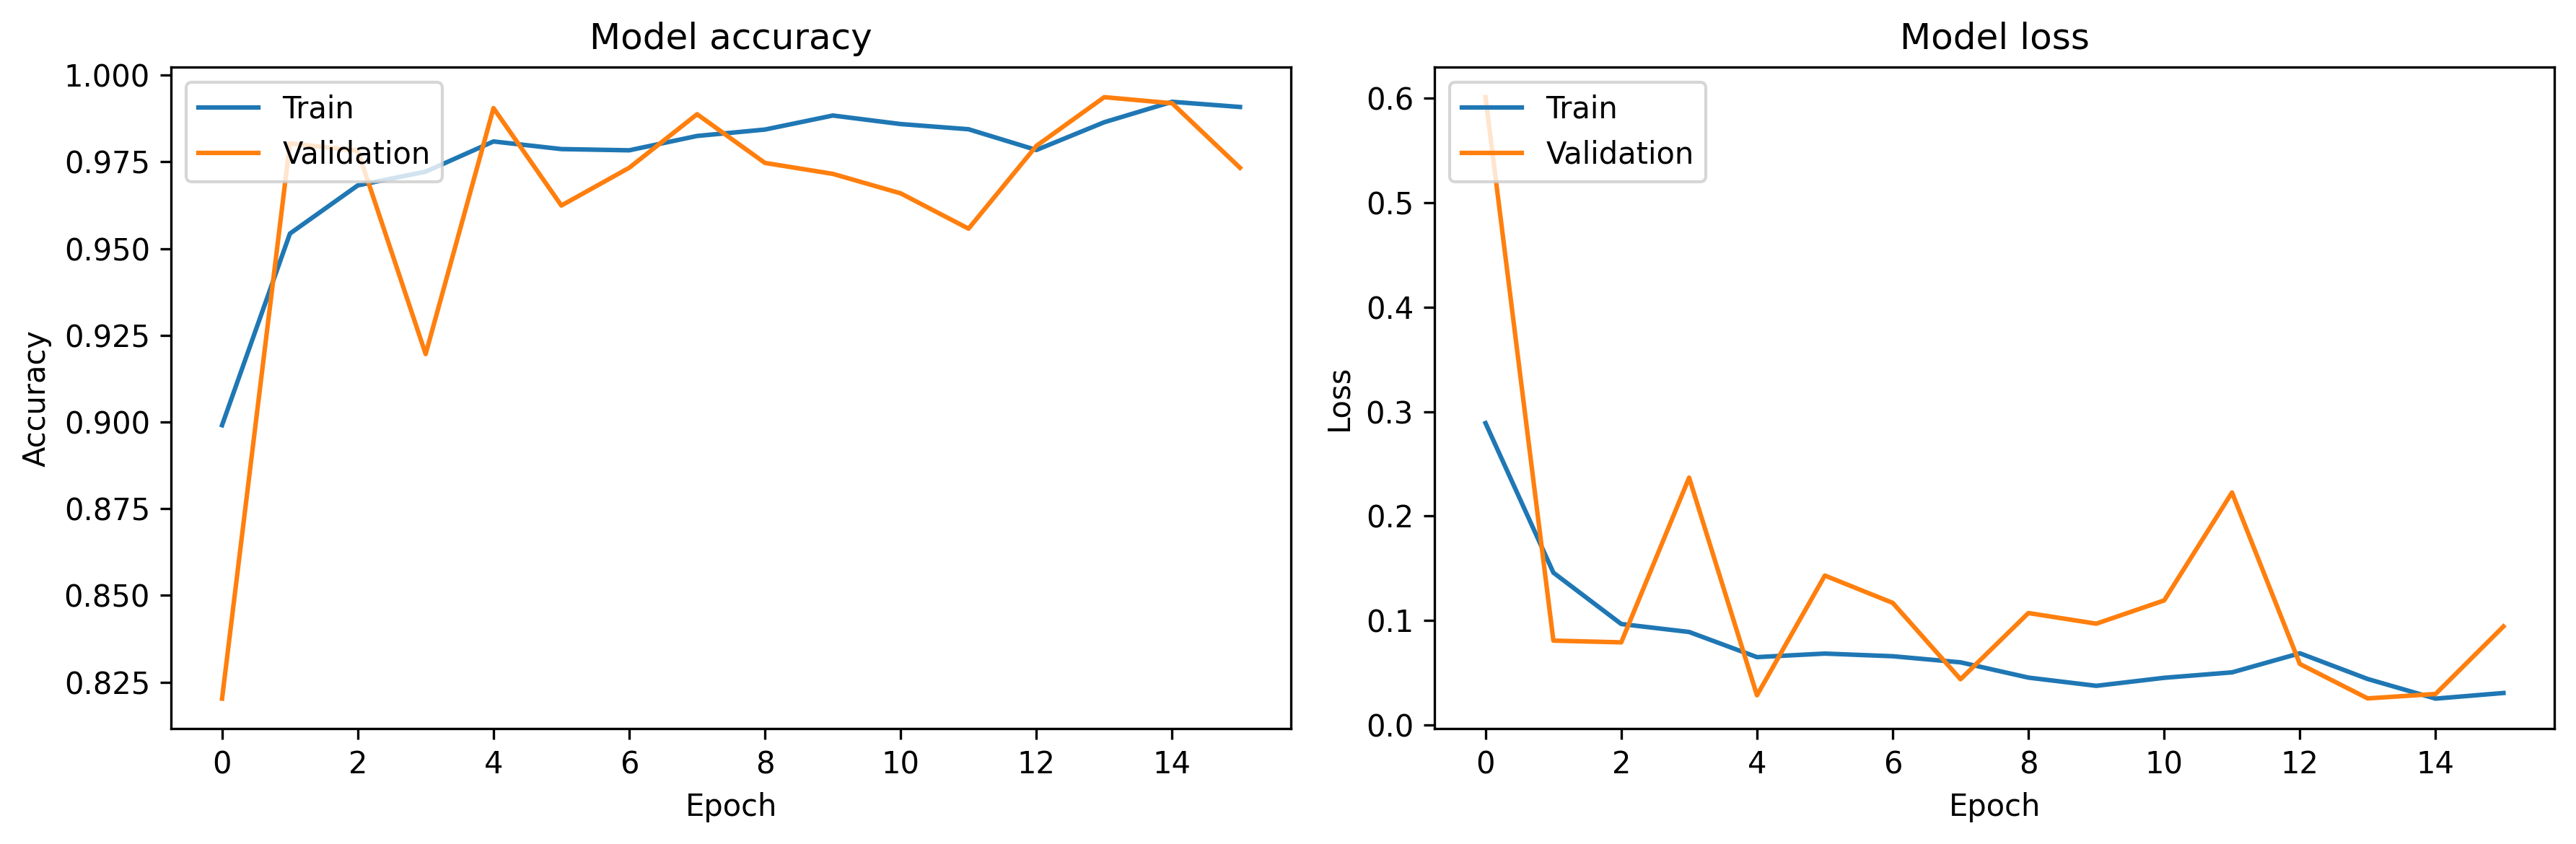

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4) ,dpi=300)

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

89/89 [==============================] - 5s 46ms/step


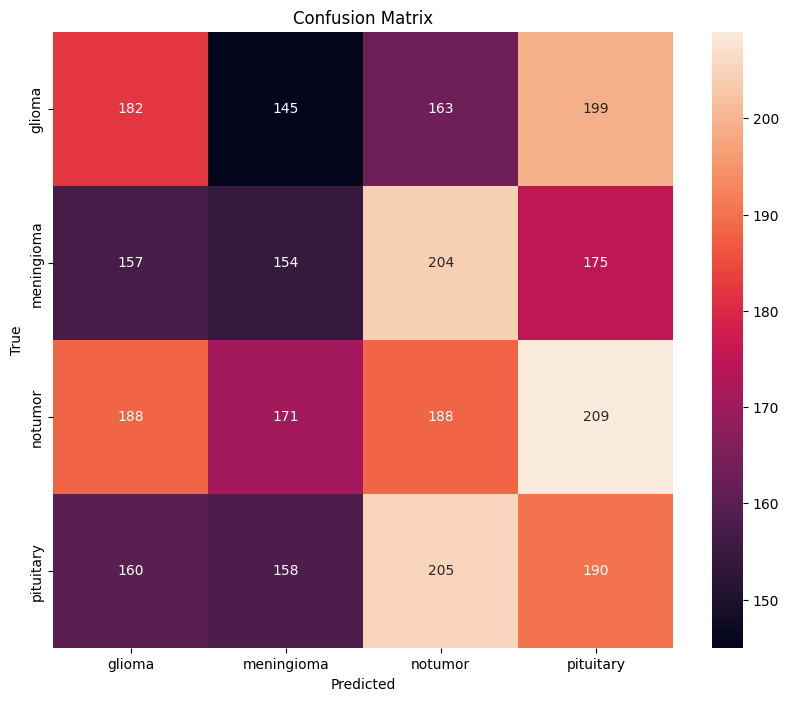

Classification Report
              precision    recall  f1-score   support

      glioma       0.26      0.26      0.26       689
  meningioma       0.25      0.22      0.23       690
     notumor       0.25      0.25      0.25       756
   pituitary       0.25      0.27      0.26       713

    accuracy                           0.25      2848
   macro avg       0.25      0.25      0.25      2848
weighted avg       0.25      0.25      0.25      2848



In [ ]:
import seaborn as sns
# Obtain true labels and predictions
validation_generator.reset()
Y_pred = model.predict(validation_generator, validation_generator.n // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())

In [ ]:
images, labels = next(validation_generator)

In [ ]:
len(labels)

32

In [ ]:
images[0].shape

(224, 224, 3)

In [ ]:
images, labels = next(validation_generator)
images = images[:num_images]
labels = labels[:num_images]

In [ ]:
def get_predictions(generator, model, num_images):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    predictions = model.predict(images)
    actual_classes = [classes[np.argmax(label)] for label in labels]
    predicted_classes = [classes[np.argmax(prediction)] for prediction in predictions]
    return images, actual_classes, predicted_classes

1/1 [==============================] - 0s 25ms/step


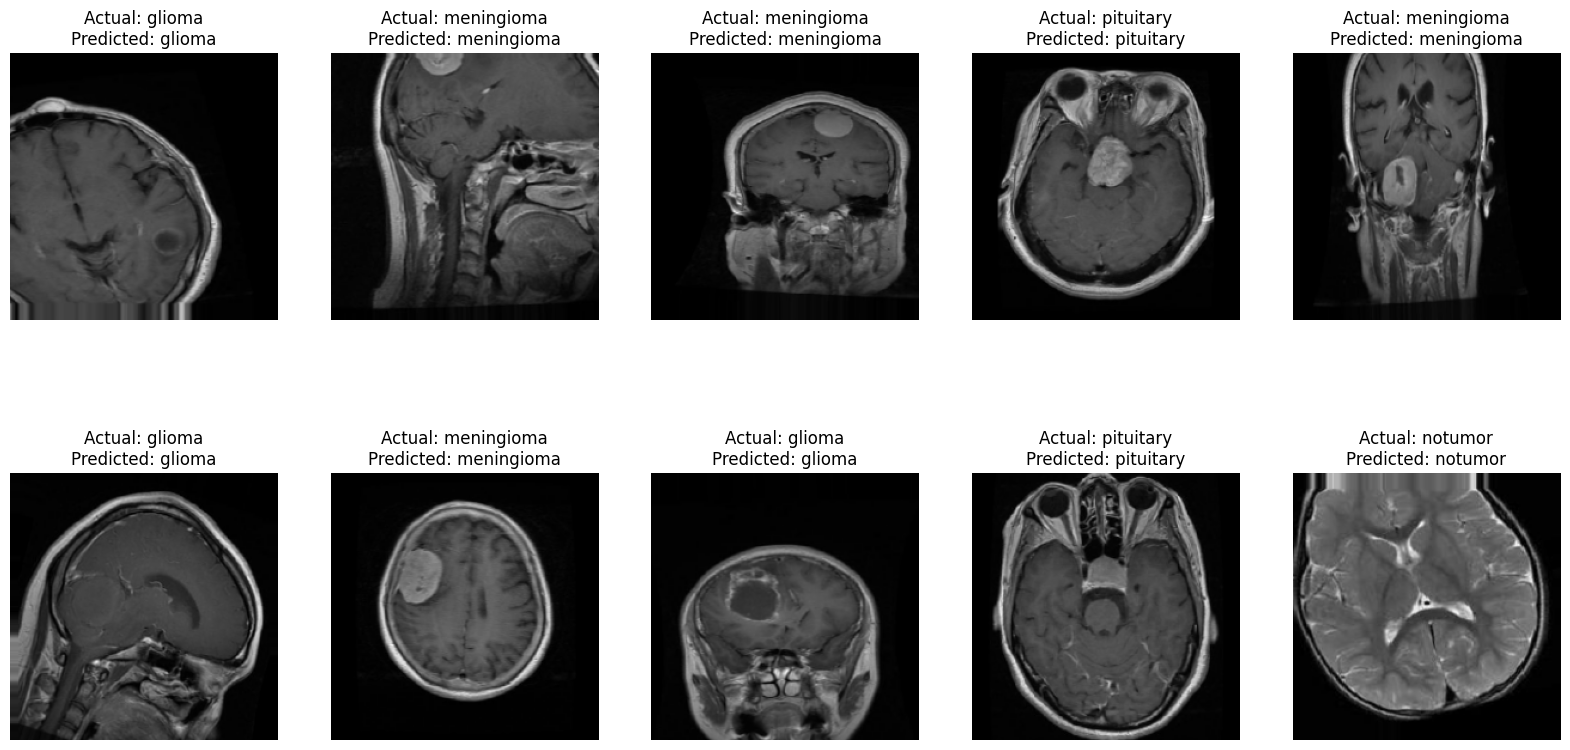

In [ ]:
num_images = 10
images, actual_classes, predicted_classes = get_predictions(train_generator, model, num_images)

# Plot the images with their actual and predicted class names
plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Actual: {actual_classes[i]}\nPredicted: {predicted_classes[i]}')
    plt.axis('off')
plt.show()

# EfficientNetB3 Model Evaluation



In [1]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 984.8 kB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB3  # Import EfficientNetB3 model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Image dimensions expected by ResNet50
BATCH_SIZE = 32
DATA_DIR = "/content/drive/MyDrive/Augmentation1/Augmentation"


In [5]:
# Using rescale, shear_range, zoom_range, horizontal_flip for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split
)

# Only rescale for validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

# Training generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Specify this is for training set
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Specify this is for validation set
)

Found 11397 images belonging to 4 classes.
Found 2848 images belonging to 4 classes.


In [6]:
num_classes = train_generator.num_classes
num_classes

4

In [7]:
from tensorflow.keras.models import load_model

path = r"/content/drive/MyDrive/model_weights/efficientnetb3_Latest.h5"
model = load_model(path)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [8]:
# Unfreeze the last few layers of the base model for fine-tuning
# for layer in base_model.layers[-10:]:
#     layer.trainable = True

# Compile the model again (always after making any changes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # Fine-tune the model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.n // BATCH_SIZE,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.n // BATCH_SIZE
# )


In [9]:
class_indices = train_generator.class_indices
classes = list(class_indices.keys())

In [10]:
images, labels = next(validation_generator)

In [11]:
len(labels)

32

In [12]:
images[0].shape

(224, 224, 3)

In [13]:
num_images =10
images, labels = next(validation_generator)
images = images[:num_images]
labels = labels[:num_images]

In [14]:
def get_predictions(generator, model, num_images):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    predictions = model.predict(images)
    actual_classes = [classes[np.argmax(label)] for label in labels]
    predicted_classes = [classes[np.argmax(prediction)] for prediction in predictions]
    return images, actual_classes, predicted_classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


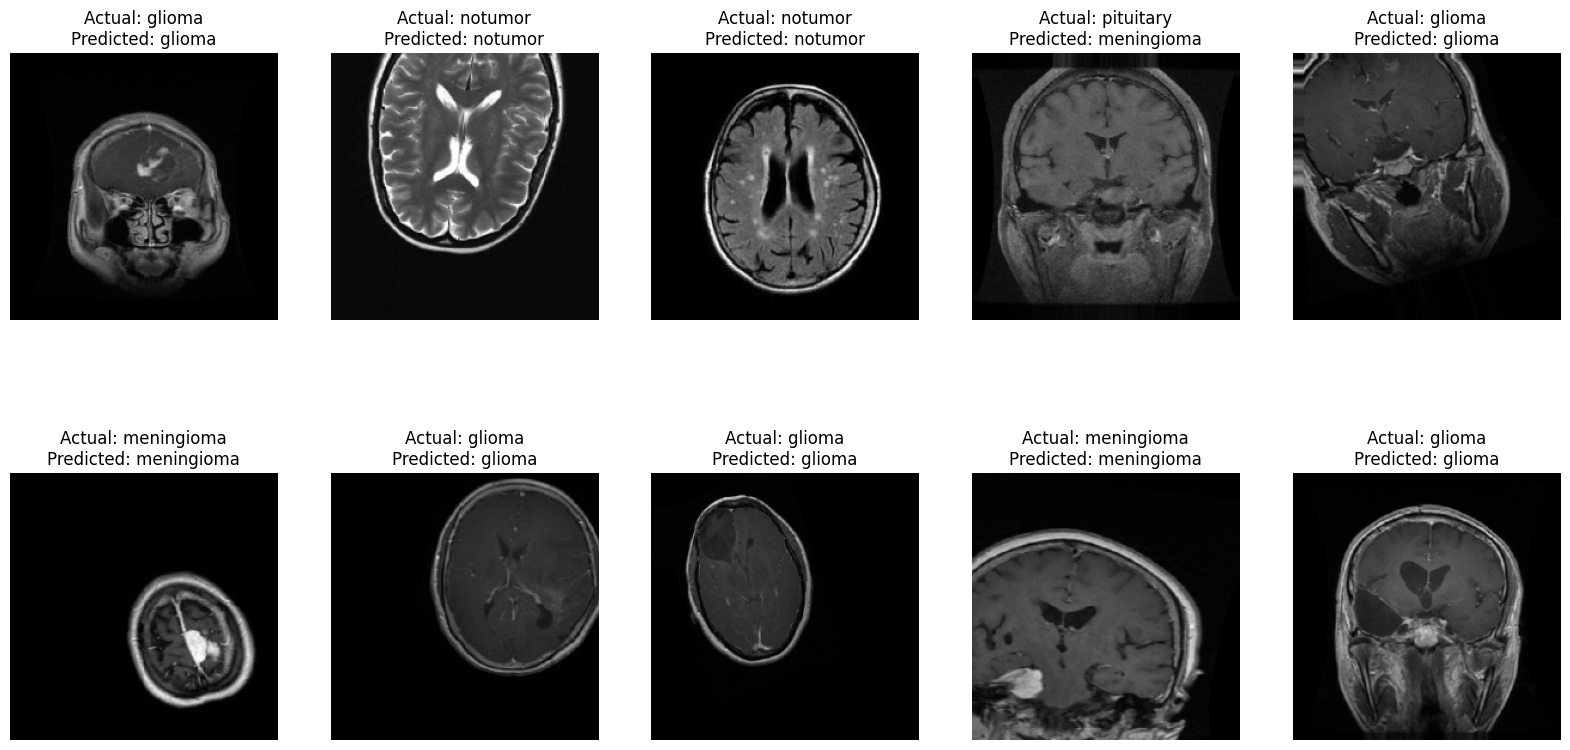

In [15]:
num_images = 10
images, actual_classes, predicted_classes = get_predictions(train_generator, model, num_images)

# Plot the images with their actual and predicted class names
plt.figure(figsize=(20, 10))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f'Actual: {actual_classes[i]}\nPredicted: {predicted_classes[i]}')
    plt.axis('off')
plt.show()

In [16]:
images, labels = next(validation_generator)

In [17]:
images= images[1,:,:,:]

In [18]:
images.shape

(224, 224, 3)

In [19]:
import tensorflow as tf
import cv2
import numpy as np

# Load the image
path = r"/content/drive/MyDrive/Augmentation1/Augmentation/meningioma/Te-meTr_0004.jpg"
img = cv2.imread(path)
img = cv2.resize(img, (224, 224))

# Convert the image to a numpy array and normalize it
img = np.array(img) / 255.0

# Expand dimensions to match the input shape expected by the model (batch_size, height, width, channels)
img = np.expand_dims(img, axis=0)

predictions = model.predict(img)

# Assuming the model's output is a probability distribution over classes
predicted_label = np.argmax(predictions, axis=-1)
predicted_index = np.argmax(predictions, axis=-1)[0]
# Get class indices from the generator
class_indices = validation_generator.class_indices

# Invert the class_indices dictionary to map indices to class names
class_names = {v: k for k, v in class_indices.items()}

# Get the predicted class name
predicted_class = class_names[predicted_index]

print(f'Predicted Label Index: {predicted_index}')
print(f'Predicted Class Name: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
Predicted Label Index: 1
Predicted Class Name: meningioma
